# Kuis 2
### Innama Maesa Putri - 3F- 16

## Load Dataset

In [1]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [2]:
df_dir = 'images/'

In [3]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = dir.name
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [5]:
df = load_dataset(df_dir)

In [38]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Shape	: (224, 224, 3)
Label	: Cucumber


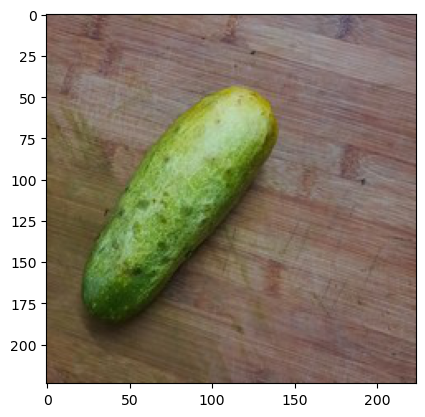

In [53]:
random_img_viz(df)

## Proses Pra Pengolahan Data

In [42]:
from tqdm import tqdm

def adaptive_gamma_correction(batch):
    processed = []
    for img, label in tqdm(batch, desc="Gamma Correction"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean = np.mean(gray)
        gamma = np.log10(0.5) / np.log10(mean / 255)
        img_corr = np.power(img / 255.0, gamma).clip(0, 1) * 255
        img_corr = img_corr.astype(np.uint8)
        processed.append((img_corr, label))
    return processed

In [43]:
gamma_result = adaptive_gamma_correction(df)

Gamma Correction:   0%|          | 0/15000 [00:00<?, ?it/s]

Gamma Correction: 100%|██████████| 15000/15000 [01:05<00:00, 230.57it/s]


Shape	: (224, 224, 3)
Label	: Carrot


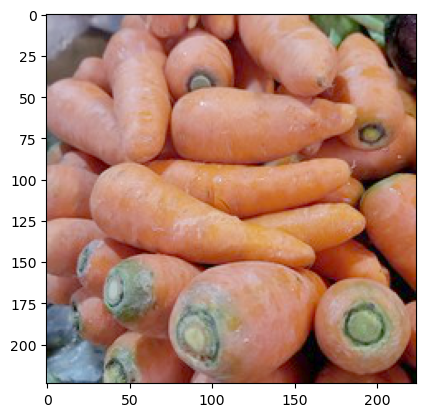

In [55]:
random_img_viz(gamma_result)

In [56]:
def apply_clahe(batch):
    processed = []
    for img, label in tqdm(batch, desc="CLAHE"):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        img_clahe = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
        processed.append((img_clahe, label))
    return processed

In [84]:
clahe_result = apply_clahe(gamma_result)

CLAHE: 100%|██████████| 15000/15000 [00:14<00:00, 1062.29it/s]


Shape	: (224, 224, 3)
Label	: Broccoli


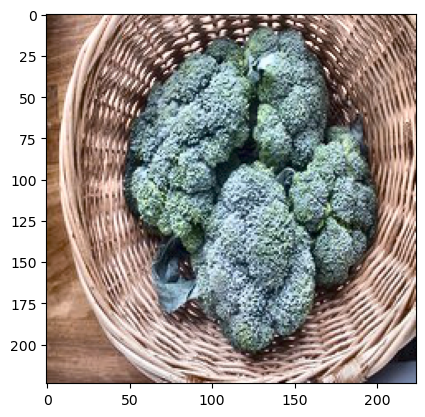

In [85]:
random_img_viz(clahe_result)

In [86]:
def remove_noise(batch):
    processed = []
    for img, label in tqdm(batch, desc="Noise Removal"):
        denoised = cv2.medianBlur(img, 3)
        processed.append((denoised, label))
    return processed

In [87]:
denoised_result = remove_noise(clahe_result)

Noise Removal: 100%|██████████| 15000/15000 [00:03<00:00, 4513.45it/s]


Shape	: (224, 224, 3)
Label	: Bean


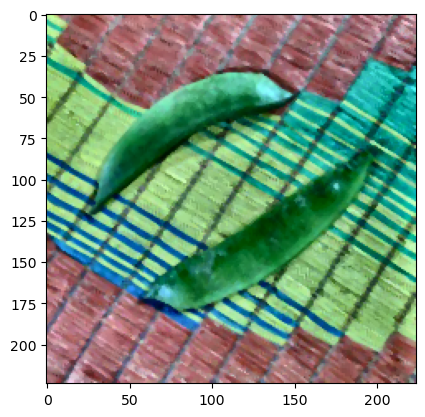

In [95]:
random_img_viz(denoised_result)

In [96]:
def adaptive_threshold_segmentation(batch):
    processed = []
    for img, label in tqdm(batch, desc="Adaptive Threshold"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            51, 5
        )
        processed.append((thresh, label))
    return processed

In [116]:
segmentation_result = adaptive_threshold_segmentation(gamma_result)

Adaptive Threshold: 100%|██████████| 15000/15000 [00:13<00:00, 1085.08it/s]


Shape	: (224, 224)
Label	: Papaya


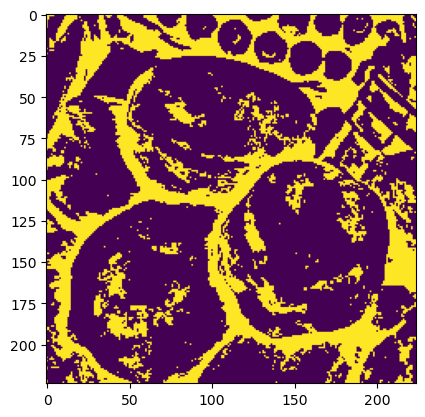

In [132]:
random_img_viz(segmentation_result)

## Ekstraksi Fitur

In [133]:
from tqdm import tqdm

def extract_sift_features(images):
    sift = cv2.SIFT_create()
    feats = []
    for img, _ in tqdm(images, desc="Ekstraksi SIFT"):
        # Pastikan citra grayscale
        if len(img.shape) == 3:  # kalau masih RGB
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        kp, des = sift.detectAndCompute(gray, None)
        if des is None:
            des = np.zeros((1, 128))
        feat = np.mean(des, axis=0)
        feats.append(feat)

    return np.array(feats)

In [135]:
images = [item[0] for item in segmentation_result]

In [137]:
features = extract_sift_features(segmentation_result)

Ekstraksi SIFT: 100%|██████████| 15000/15000 [31:45<00:00,  7.87it/s]


In [138]:
features

array([[13.12     ,  5.08     ,  0.6      , ...,  9.8      ,  2.36     ,
         2.8      ],
       [23.336044 , 16.707317 , 13.081301 , ..., 17.821138 ,  8.084011 ,
         8.411924 ],
       [18.739796 , 15.010204 , 15.678572 , ..., 16.147959 ,  9.382653 ,
         8.790816 ],
       ...,
       [20.845455 , 19.272728 , 13.527273 , ..., 12.945455 ,  7.981818 ,
         7.6363635],
       [23.874434 , 20.928896 , 15.962178 , ..., 18.420574 , 12.674735 ,
        13.692889 ],
       [22.649214 , 23.13089  , 21.005236 , ..., 18.628273 , 13.774869 ,
        13.891798 ]], shape=(15000, 128), dtype=float32)